In [ ]:

import pandas as pd
import dask

import matplotlib.dates as dates
import matplotlib.ticker as ticker


In [72]:
import numpy as np 
import xarray as xr
import os
import shapely
import geopandas as gpd
import salem

from matplotlib import pyplot as plt
%matplotlib inline

### Load salinity from ASTE

In [5]:
varname = 'SALT'
base_dir = '/mnt/efs/data/aste/nctiles_monthly/'

In [11]:
aste = xr.open_mfdataset(os.path.join(base_dir, varname, '*.nc'),concat_dim='tile')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [19]:
aste = aste.rename({'i1': 't','i2': 'k','i3': 'j','i4': 'i','tim': 'time','dep': 'depth'})
aste = aste.swap_dims({'t': 'time'})   

In [20]:
aste

<xarray.Dataset>
Dimensions:  (i: 90, j: 90, k: 50, tile: 29, time: 192)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-16 2002-02-13 ... 2017-12-16
    depth    (k) float64 dask.array<chunksize=(50,), meta=np.ndarray>
  * j        (j) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 86.0 87.0 88.0 89.0 90.0
  * k        (k) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 46.0 47.0 48.0 49.0 50.0
    t        (time) float64 1.0 2.0 3.0 4.0 5.0 ... 189.0 190.0 191.0 192.0
  * i        (i) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 86.0 87.0 88.0 89.0 90.0
    lon      (tile, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    lat      (tile, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
Dimensions without coordinates: tile
Data variables:
    SALT     (tile, time, k, j, i) float32 dask.array<chunksize=(1, 192, 50, 90, 90), meta=np.ndarray>
    timstep  (tile, time) float64 dask.array<chunksize=(1, 192), meta=np.ndarray>
    land     (tile, k, j, i) float64 dask.array<chunksize=(1, 50, 90, 90), meta=np.ndarray>
    area     (tile, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    thic     (tile, k) float64 dask.array<chunksize=(1, 50), meta=np.ndarray>
Attributes:
    Description:     Arctic Subpolar Gyre sTate Estimate (ASTE) release 1
    Institution:     Oden Institute for Computational Engineering and Science...
    References:        
    01:                 Nguyen, A.T., D. Menemenlis, and R. Kwok. 2011.
    02:                 Arctic ice-ocean simulation with optimized model para...
    03:                 Journal of Geophysical Research 116, C04025
    04:                 
    05:                 Nguyen, A.T., V. Oca��a, V. Garg, P. Heimbach, J.M. T...
    06:                 On the benefit of current and future ALPS data for im...
    07:                 Oceanography 30(2):40-44
    Conventions:     CF-1.6 (http://cfconventions.org/cf-conventions/v1.6.0/c...
    Software:        File created using convert_ASTE2nctiles_DIAG.m
    netCDF Version:  4.3.3.1
    matlab Version:  9.3.0.713579 (R2017b)
    _FillValue:      nan
    missing_value:   nan

### Liquid freshwater content
The freshwater content (in meters) for each grid point is estimated as
$$ h_{fw} = \int_D^\eta f \, dz = \int_D^\eta \frac{S_{ref} - S}{S_{ref}} \, dz$$

In [55]:
SALT = aste.SALT.where(aste.SALT > 0)

In [58]:
# Reference salinity
Sref = 35.0

# Liquid freshwater content
f = (Sref - SALT.transpose('time','tile','k','j','i'))/Sref

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  """


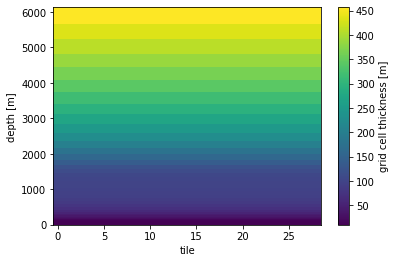

In [39]:
aste.thic.swap_dims({'k': 'depth'}).T.plot()

In [60]:
h_fw = (f * aste.thic).sum('k')

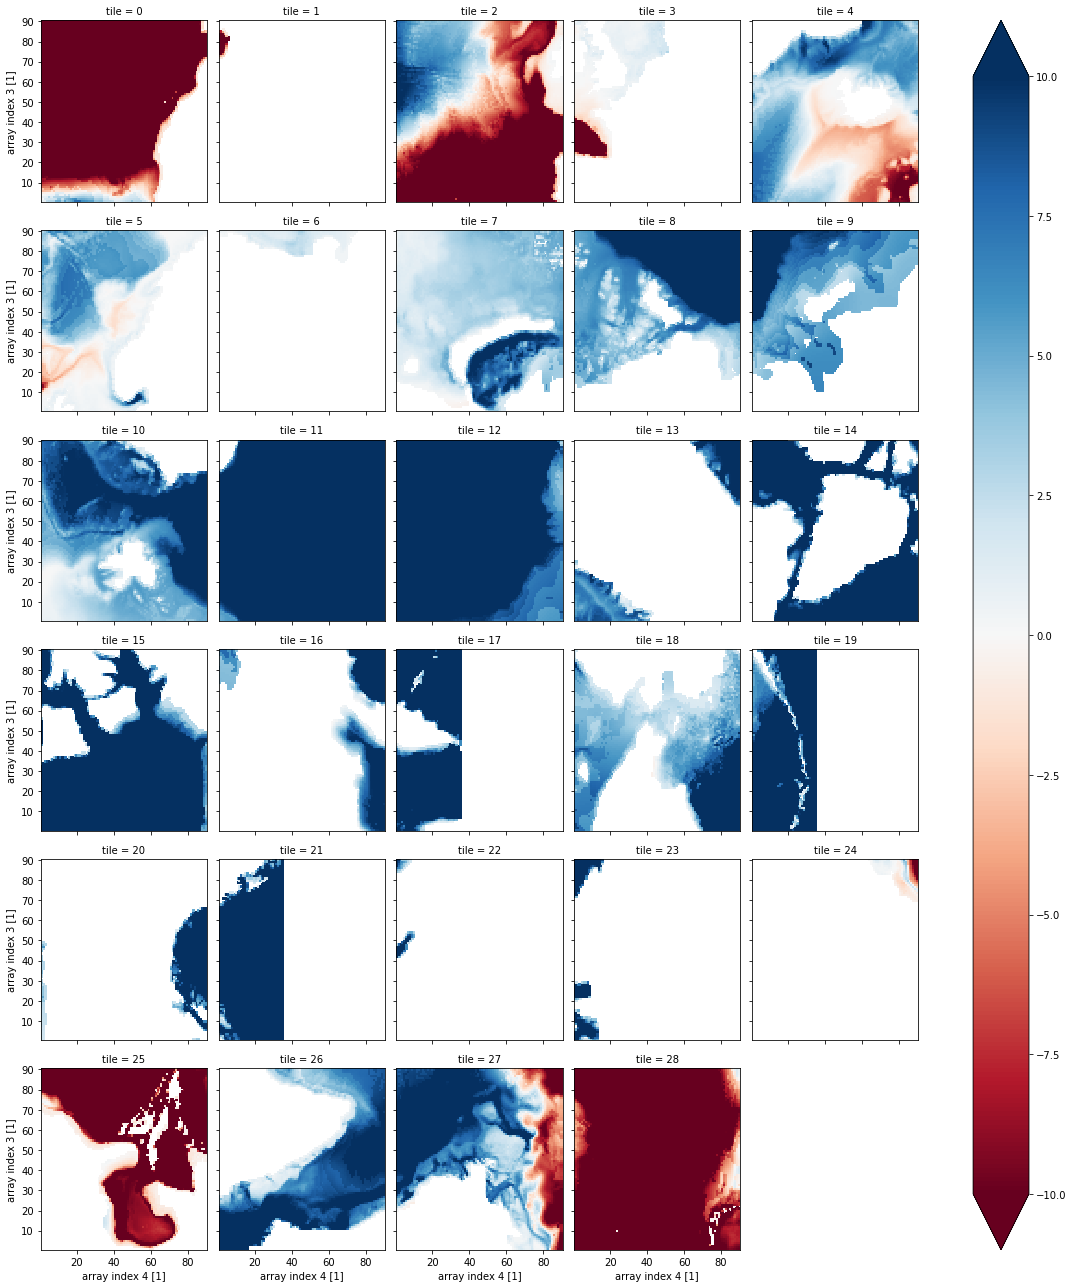

In [61]:
h_fw[0].where(aste.land[:,0].values==1).plot(col='tile', col_wrap=5, vmin=-10,vmax=10, cmap='RdBu')

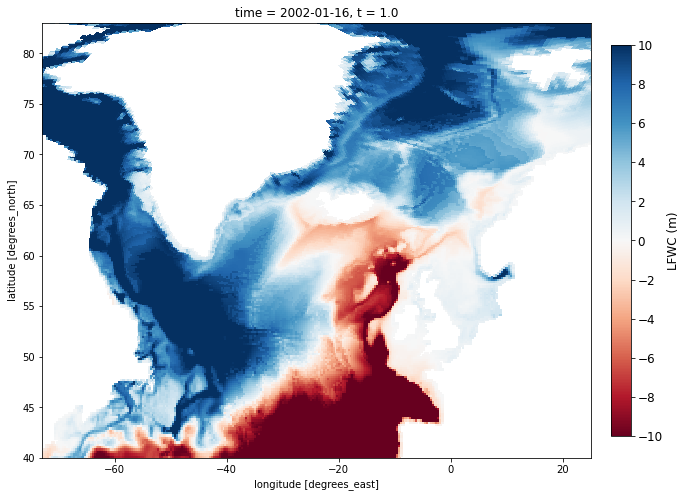

In [101]:
fig, ax = plt.subplots(figsize=(12,8))

p=h_fw[0,5].where(aste.land[5,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')
h_fw[0,4].where(aste.land[4,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')
h_fw[0,3].where(aste.land[3,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')
h_fw[0,2].where(aste.land[2,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')
h_fw[0,26].where(aste.land[26,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')
h_fw[0,27].where(aste.land[27,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')

h_fw[0,15].where(aste.land[15,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')

h_fw[0,14].where(aste.land[14,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')
h_fw[0,13].where(aste.land[13,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')

h_fw[0,23].where(aste.land[23,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')
h_fw[0,24].where(aste.land[24,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')


h_fw[0,10].where(aste.land[10,0].values==1).plot(ax=ax, x='lon', y='lat', add_colorbar=False, 
                                                 vmin=-10, vmax=10, cmap='RdBu')
ax.set_xlim([-73,25])
ax.set_ylim([40,83])

cbar = fig.colorbar(p, ax=ax, ticks=np.arange(-10,12,2),shrink=0.9, pad = 0.03)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'LFWC (m)', fontsize=12)

plt.show()

### Spatially integrate to obtain the liquid freshwater content (LFWC)
$$LFWC = \oint h_{fw}\; dA$$

In [62]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [63]:
coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]

In [64]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [108]:
# Create mask for SPNA
df = aste.coords.to_dataset().get(['lon','lat']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.lon, df.lat)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('tile','j','i')
aste['mask_spna'] = mask_spna.where(aste.land[:,0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('tile','j','i')
aste['mask_nsea'] = mask_nsea.where(aste.land[:,0].values==1,0)

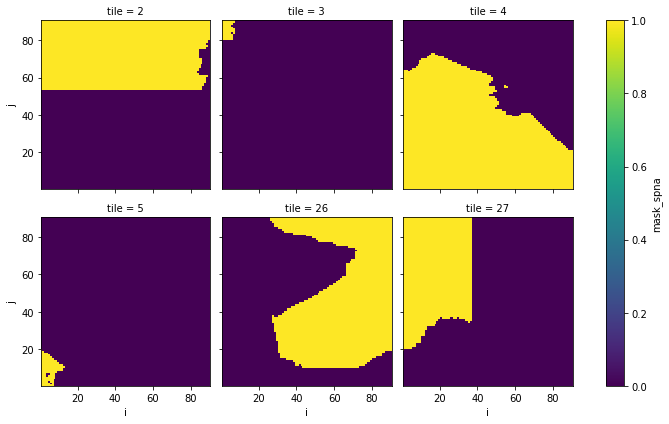

In [111]:
aste['mask_spna'].sel(tile=[2,3,4,5,26,27]).plot(col='tile', col_wrap=3)

In [124]:
h_fw_spna = (h_fw*aste.area)*aste.mask_spna.where(aste.mask_spna==1)
h_fw_nsea = (h_fw*aste.area)*aste.mask_nsea.where(aste.mask_nsea==1)

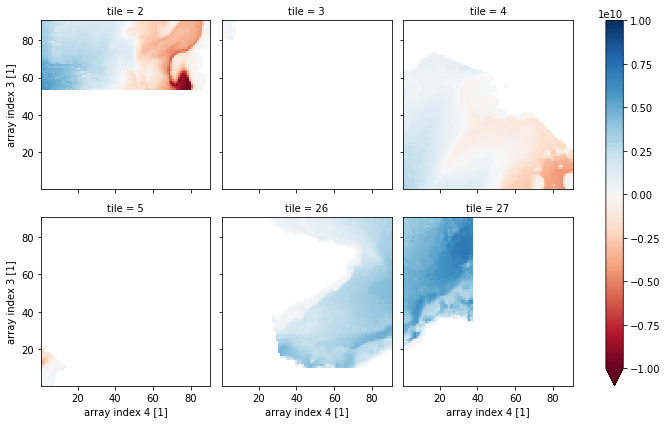

In [122]:
h_fw_spna[0].sel(tile=[2,3,4,5,26,27]).plot(col='tile', col_wrap=3, vmin=-1e10, vmax=1e10, cmap='RdBu')

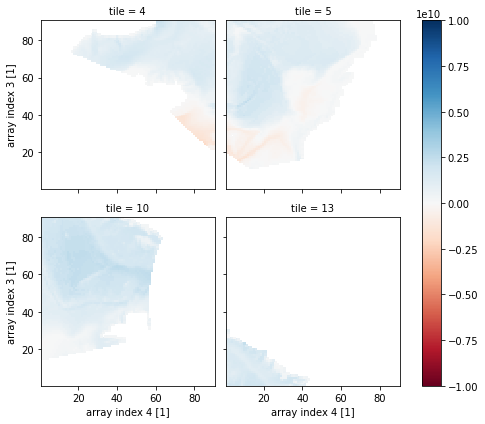

In [126]:
h_fw_nsea[0].sel(tile=[4,5,10,13]).plot(col='tile', col_wrap=2, vmin=-1e10, vmax=1e10, cmap='RdBu')

In [127]:
h_fw_spna

<xarray.DataArray (time: 192, tile: 29, j: 90, i: 90)>
dask.array<mul, shape=(192, 29, 90, 90), dtype=float64, chunksize=(192, 1, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 ... 19 20 21 22 23 24 25 26 27 28
  * time     (time) datetime64[ns] 2002-01-16 2002-02-13 ... 2017-12-16
  * j        (j) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 86.0 87.0 88.0 89.0 90.0
    t        (time) float64 1.0 2.0 3.0 4.0 5.0 ... 189.0 190.0 191.0 192.0
  * i        (i) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 86.0 87.0 88.0 89.0 90.0
    lon      (tile, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    lat      (tile, j, i) float64 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>

In [130]:
# Sum over area and convert to km^3
Vfw_spna = h_fw_spna.sum(dim=['tile','j','i'])*1e-9
Vfw_nsea = h_fw_nsea.sum(dim=['tile','j','i'])*1e-9

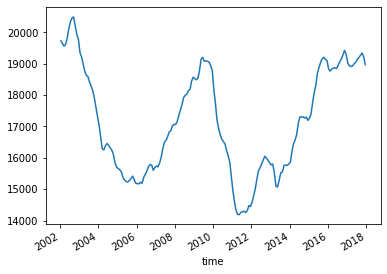

In [132]:
Vfw_spna.plot()

In [137]:
ds_spna = Vfw_spna.reset_coords(drop=True).to_dataset(name='lfwc')

In [139]:
ds_spna.to_netcdf('/mnt/efs/data/aste/aste_lfwc_spna_monthly.nc', format='NETCDF4',
                  encoding={'lfwc':   {'zlib': True}})

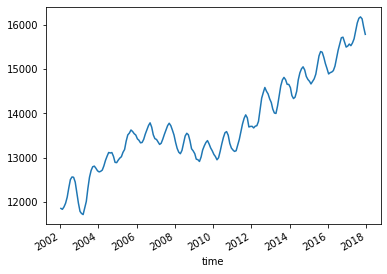

In [135]:
Vfw_nsea.plot()

In [140]:
ds_nsea = Vfw_nsea.reset_coords(drop=True).to_dataset(name='lfwc')

In [141]:
ds_nsea.to_netcdf('/mnt/efs/data/aste/aste_lfwc_nsea_monthly.nc', format='NETCDF4',
                  encoding={'lfwc':   {'zlib': True}})

In [133]:
# Anomaly
Vfw_spna_anom = Vfw_spna - Vfw_spna.mean('time')
Vfw_nsea_anom = Vfw_nsea - Vfw_nsea.mean('time')

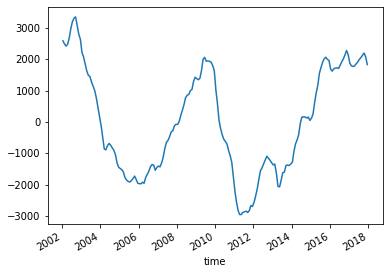

In [134]:
Vfw_spna_anom.plot()

In [143]:
ds_spna = Vfw_spna_anom.reset_coords(drop=True).to_dataset(name='lfwc')

In [144]:
ds_spna.to_netcdf('/mnt/efs/data/aste/aste_lfwc_spna_monthly_anom.nc', format='NETCDF4',
                  encoding={'lfwc':   {'zlib': True}})

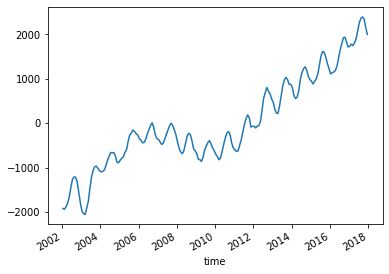

In [145]:
Vfw_nsea_anom.plot()

In [146]:
ds_nsea = Vfw_nsea_anom.reset_coords(drop=True).to_dataset(name='lfwc')

In [147]:
ds_nsea.to_netcdf('/mnt/efs/data/aste/aste_lfwc_nsea_monthly_anom.nc', format='NETCDF4',
                  encoding={'lfwc':   {'zlib': True}})